In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive")
os.listdir()

['Colab Notebooks',
 'train_images',
 'csv',
 'SSD',
 'utils',
 '.ipynb_checkpoints']

In [ ]:
%matplotlib inline
import numpy as np # Linear Algebra
import gc
import pandas as pd # Data Processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook

import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision
from torchvision.ops import RoIAlign
from torchsummary import summary


from PIL import Image, ImageDraw,ImageFont
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import json
import re
from joblib import Parallel,delayed
import random
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import timeit
from SSD.box_utils import cxcy_to_gcxgcy,cxcy_to_xy,gcxgcy_to_cxcy,xy_to_cxcy
from SSD.ssd import SSD
from SSD.loss import MultiBoxLoss
from SSD.dataset import SSDDataset
from SSD.iou import bb_intersection_over_union

# Things to do to improve results
- Scale Prediction
- Add GIOU
- Add Decoder
- Add noise in the dataset

# Dataset

In [ ]:
data=pd.read_csv("csv/train.csv")
data.head()

image_name                 label  ...  xmax  ymax
0  0181 copie.jpg          0181 copie_0  ...   545  1040
1  0181 copie.jpg  0181 copie_0_flipped  ...  1210  1038
2  0181 copie.jpg          0181 copie_1  ...   861  1080
3  0181 copie.jpg          0181 copie_2  ...   419  1380
4  0181 copie.jpg          0181 copie_2  ...  1275  1379

[5 rows x 7 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606 entries, 0 to 4605
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     4606 non-null   object
 1   label          4606 non-null   object
 2   template_name  4606 non-null   object
 3   xmin           4606 non-null   int64 
 4   ymin           4606 non-null   int64 
 5   xmax           4606 non-null   int64 
 6   ymax           4606 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 252.0+ KB


In [ ]:
image_names=list(data['image_name'].unique())
imageArray=pd.DataFrame({"image_name":[],"image_array":[]})
for im in image_names:
  img=Image.open("train_images/"+im)
  imageArray=pd.concat([imageArray,pd.DataFrame({"image_name":[im],"image_array":[np.array(img)]})])
  del img

In [ ]:
imageArray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 0
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   18 non-null     object
 1   image_array  18 non-null     object
dtypes: object(2)
memory usage: 432.0+ bytes


In [ ]:
# Merge the data with imageData to get array of the images
#data=pd.merge(data,imageData,on="image_name")

In [ ]:
# We don't need to save the image array for every cropped image, we will save the information about the co-ordinates
imageData=pd.DataFrame({"image_name":[],"x_min":[],"y_min":[],"x_max":[],"y_max":[]})
imageData["image_name"]=imageArray['image_name']

In [ ]:
imageData["x_min"]=imageData["image_name"].apply(lambda x:0)
imageData["y_min"]=imageData["image_name"].apply(lambda x:0)
imageData["x_max"]=imageData["image_name"].apply(lambda x:
                                                 imageArray[imageArray["image_name"]==x]["image_array"][0].shape[1])
imageData["y_max"]=imageData["image_name"].apply(lambda x:
                                                 imageArray[imageArray["image_name"]==x]["image_array"][0].shape[0])

In [ ]:
img_name=imageData['image_name'].unique()[1]
original_image_name=img_name
# Image
crop_coord=imageData[imageData['image_name']==img_name][["x_min","y_min","x_max","y_max"]].values[0]
image=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]:crop_coord[3],
                                                                crop_coord[0]:crop_coord[2],:]

In [ ]:
# Encode the labels with Int
labels=data["label"]
le=LabelEncoder()
data['label']=le.fit_transform(labels)+1

In [ ]:
def random_crop(num,im):
    """ Randomly Crop an Image with a fixed size """
    global imageData
    global data
    img=Image.open("train_images/"+im)
    w,h=img.width,img.height
    #img=np.array(img)
    #new_dataset=dataset.copy()
    #new_imageData=image_dataset.copy()
    if w>2000:
        new_w=640
    if h>2000:
        new_h=640
    new_x=np.random.randint(0,w-2*new_w)
    new_y=np.random.randint(0,h-new_h)

    # New cropped Image
    #new_img=img[new_y:new_y+new_h,new_x:new_x+new_w]
    name=im.split(".")[0] +"_cropped_"+str(num)+".jpg"
    boxes=[]
    #pil_image=Image.fromarray(new_img)
    image_dataset=data[data['image_name']==im]
    imageData=pd.concat([imageData,pd.DataFrame({'image_name':[name],"x_min":[new_x],
                                                 "y_min":[new_y],"x_max":[new_x+new_w],
                                                 "y_max":[new_y+new_h]})],axis=0)
    
    #start = timeit.default_timer()

    for i in range(len(image_dataset)):
        change=False
        tm=image_dataset.iloc[i]
        area_old=(tm['xmax']-tm['xmin'])*(tm['ymax']-tm['ymin'])
        if tm['xmin']>=new_x and tm['ymin']>=new_y and tm['xmax']<new_x+new_w and tm['ymax']<new_y+new_h:
            change=True
            tm['xmin']-=new_x
            tm['ymin']-=new_y
            tm['xmax']-=new_x
            tm['ymax']-=new_y
        elif tm['xmax']<new_x+new_w and tm['ymax']<new_y+new_h and tm['xmax']>=new_x and tm['ymax']>=new_y:
            change=True
            tm['xmax']-=new_x
            tm['ymax']-=new_y
            if tm['xmin']<=new_x:
              tm['xmin']=0
            else:
              tm['xmin']-=new_x
            if tm['ymin']<=new_y:
              tm['ymin']=0
            else:
              tm['ymin']-=new_y
        
        elif tm['xmin']>new_x and tm['ymin']>new_y and tm['xmin']<=new_x+new_w and tm['ymin']<=new_y+new_h:
            change=True
            tm['xmin']-=new_x
            tm['ymin']-=new_y
            if tm['xmax']>=new_x+new_w:
              tm['xmax']=new_w-1
            else:
              tm['xmax']-=new_x
            if tm['ymax']>=new_y+new_h:
              tm['ymax']=new_h-1
            else:
              tm['ymax']-=new_y
        area_new=(tm['xmax']-tm['xmin'])*(tm['ymax']-tm['ymin'])
        if change and area_new/area_old>0.75:
            #tm['imageData']=new_img
            temp=pd.DataFrame({"image_name":[name],"label":[tm["label"]],
                               "template_name":[tm["template_name"]],"xmin":[tm["xmin"]],
                               "ymin":[tm["ymin"]],"xmax":[tm["xmax"]],
                               "ymax":[tm["ymax"]]})
            data=pd.concat([data,temp],axis=0)

        
        gc.collect()
    #stop = timeit.default_timer()
    #print(f'Time taken for Image {im} Number {num}: ', stop - start,"\n")
        

In [ ]:
def plot_box(data,img_no=1):
    img_name=data['image_name'].unique()[img_no]
    if "_" in img_name:
      original_image_name=img_name.split("_")[0]+".jpg"
    else:
      original_image_name=img_name
    boxes=data[data['image_name']==img_name][['xmin','ymin','xmax','ymax']].values
    # Image
    crop_coord=imageData[imageData['image_name']==img_name][["x_min","y_min","x_max","y_max"]].values[0]
    image=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]:crop_coord[3],
                                                                crop_coord[0]:crop_coord[2],:]

    image=Image.fromarray(image)

    # Draw rectangle
    img1=ImageDraw.Draw(image)
    for bx in boxes:
      img1.rectangle(tuple(bx),outline="red")
    
    return image

In [ ]:
"""for im in image_names[5:10]:
  #Parallel(n_jobs=5)(delayed(random_crop)(i,im) for i in range(1,100))
  start = timeit.default_timer()
  for i in range(1,100):
      random_crop(i,im)
  stop = timeit.default_timer()
  print(f'Time taken for Image {im} : ', (stop - start)/60," minutes ","\n")
  print(len(imageData),len(data))"""

'for im in image_names[5:10]:\n  #Parallel(n_jobs=5)(delayed(random_crop)(i,im) for i in range(1,100))\n  start = timeit.default_timer()\n  for i in range(1,100):\n      random_crop(i,im)\n  stop = timeit.default_timer()\n  print(f\'Time taken for Image {im} : \', (stop - start)/60," minutes ","\n")\n  print(len(imageData),len(data))'

In [ ]:
#imageData.to_csv("/content/gdrive/MyDrive/csv/imageData_2.csv",index=None)

In [ ]:
#data.to_csv("/content/gdrive/MyDrive/csv/data_2.csv",index=None)

In [ ]:
imageData=pd.read_csv("/content/gdrive/MyDrive/csv/imageData_3.csv")
data=pd.read_csv("/content/gdrive/MyDrive/csv/data_3.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36537 entries, 0 to 36536
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     36537 non-null  object
 1   label          36537 non-null  int64 
 2   template_name  36537 non-null  object
 3   xmin           36537 non-null  int64 
 4   ymin           36537 non-null  int64 
 5   xmax           36537 non-null  int64 
 6   ymax           36537 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.0+ MB


In [ ]:
imageData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1800 non-null   object
 1   x_min       1800 non-null   int64 
 2   y_min       1800 non-null   int64 
 3   x_max       1800 non-null   int64 
 4   y_max       1800 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 70.4+ KB


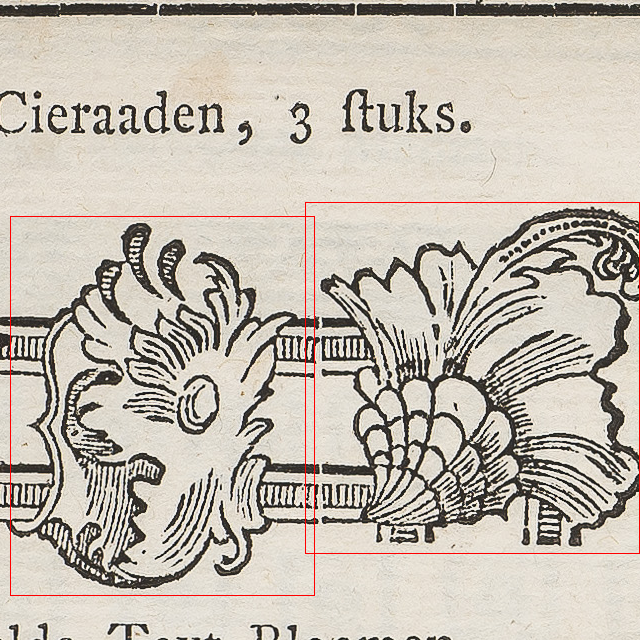

In [ ]:
plot_box(data,30)

In [ ]:
class SSDDataset(Dataset):
    def __init__(self, data, imageData, imageArray, is_test=False, transform=None):
        #self.annotation_folder_path = csv_path
        self.data=data # Contains the information about bounding boxes
        self.imageData=imageData # Contains the coordinate of the cropped images
        self.imageArray=imageArray # Contains the arrays of the original 18 images
        self.all_images=self.data['image_name'].unique()
        self.transform = transform
        self.is_test = is_test
        
    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        if "_" in img_name:
          original_img_name=img_name.split("_")[0]+".jpg"
        else:
          original_img_name=img_name
        coord=self.imageData[self.imageData['image_name']==img_name][["x_min","y_min","x_max","y_max"]].values[0]
        img = Image.fromarray(self.imageArray[self.imageArray['image_name']==original_img_name]['image_array'].values[0][
            int(coord[1]):int(coord[3]),int(coord[0]):int(coord[2]),:])
        img = img.convert('RGB')
        
        if not self.is_test:
            annotations=self.data[self.data['image_name']==img_name]

            self.box = self.get_xy(annotations)

            self.new_box = torch.FloatTensor(self.box_resize(self.box, img)).cuda()
            if self.transform is not None:
                img = self.transform(img)
            

            self.labels=torch.FloatTensor(annotations['label'].values).cuda()

            """# Encode the labels with Int
            self.le=LabelEncoder()
            self.labels=torch.FloatTensor(self.le.fit_transform(self.labels))"""

            return img, self.new_box, self.labels
        else:
            return img
    
    def __len__(self):
        return len(self.all_images)
        
    def get_xy(self, annotation):
        boxes=torch.FloatTensor(annotation[['xmin','ymin','xmax','ymax']].values)
        return boxes
        
    def box_resize(self, box, img, dims=(300, 300)):
        old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
        new_box = box / old_dims
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        #new_box = new_box * new_dims
        
        return new_box
    
    def collate_fn(self, batch):
        """
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
#         difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
#             difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [ ]:
#data.iloc[4606:,:]

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:

tsfm = transforms.Compose([
    transforms.Resize([300,300]),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    AddGaussianNoise(0., 1.)])

# Batch Size
BS=8

In [ ]:
train_ds = SSDDataset(data.iloc[4606:,:], imageData,imageArray, transform=tsfm)
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, collate_fn=train_ds.collate_fn)

"""valid_ds = SSDDataset(x_test,imageData,imageArray, transform=None)
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=True, collate_fn=valid_ds.collate_fn)"""

'valid_ds = SSDDataset(x_test,imageData,imageArray, transform=None)\nvalid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=True, collate_fn=valid_ds.collate_fn)'

In [ ]:
"""x=next(iter(train_dl))
img=Image.fromarray(np.moveaxis(np.array(x[0][3]*255,dtype=np.uint8),0,-1))
boxes=x[1][3]*300"""

'x=next(iter(train_dl))\nimg=Image.fromarray(np.moveaxis(np.array(x[0][3]*255,dtype=np.uint8),0,-1))\nboxes=x[1][3]*300'

In [ ]:
"""draw = ImageDraw.Draw(img)
for i,bx in enumerate(boxes):
    box_location = bx.tolist()
    #box_location=bx
    draw.rectangle(xy=box_location, outline='red')
    #draw.rectangle(xy=list(map(lambda x:x+1, box_location)), outline='red')"""

"draw = ImageDraw.Draw(img)\nfor i,bx in enumerate(boxes):\n    box_location = bx.tolist()\n    #box_location=bx\n    draw.rectangle(xy=box_location, outline='red')\n    #draw.rectangle(xy=list(map(lambda x:x+1, box_location)), outline='red')"

In [ ]:
#img

# SSD model

# Train

In [ ]:

N_CLASSES=data['label'].nunique()+1 # +1 for background
EPOCH = 100
LR = 1e-5
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
print_feq = 100

In [ ]:
model = SSD(n_classes=N_CLASSES).cuda()
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy,losstype="giou").cuda()
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=LR,  weight_decay=weight_decay)


Loaded base model.



In [ ]:
criterion.loss

IouLoss()

In [ ]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/SSD/model_giou_1b_noise.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import time
for epoch in range(1, EPOCH+1):
    model.train()
    train_loss = []
    time_start=time.time()
    for step, (img, boxes, labels) in enumerate(tqdm_notebook(train_dl)):
        time_1 = time.time()
        img = img.cuda()
        # Box = torch.cat(box)
        boxes = [box.cuda() for box in boxes]
        # Label = torch.cat(label)
        labels = [label.cuda() for label in labels]
        
        pred_loc, pred_sco = model(img)
        
        loss = criterion(pred_loc, pred_sco, boxes, labels)
        
        # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Losses.update(loss.item(), images.size(0))
        train_loss.append(loss.item())
    time_end=time.time()
    total_time=str((time_end-time_start)//60)+" minutes and "+ str(np.round((time_end-time_start)%60,2))+" seconds "
    torch.save(model.state_dict(),"/content/gdrive/MyDrive/SSD/model_giou_1b_noise.pth")
        
        
    print("Time:",total_time, ' epoch: ', epoch, '/', EPOCH,
            'train loss:', '{:.4f}'.format(np.mean(train_loss)))


Time: 2.0 minutes and 22.5 seconds   epoch:  1 / 100 train loss: 0.3478


KeyboardInterrupt: ignored

In [ ]:
#torch.save(model.state_dict(),"/content/gdrive/MyDrive/SSD/model_giou.pth")

In [ ]:
#model_giou=SSD(n_classes=N_CLASSES).cuda()
#model_giou.load_state_dict(torch.load("/content/gdrive/MyDrive/SSD/model_giou.pth"))

# test

In [ ]:
model.eval();
#del train_ds, train_dl, valid_ds, valid_dl

In [ ]:
from random import randint
def non_max_supression(box,label,score):
    new_box=[]
    new_score=[]
    new_label=[]

    for i,ob in enumerate(box):
        update=True
        for j,nb in enumerate(new_box):
            if bb_intersection_over_union(ob,nb)>0.2:
                if new_label[j]==label[i] and new_score[j]<score[i]:
                    new_box[j]=ob
                    new_score[j]=score[i]
                    update=False
                    break
                else:
                    update=False
                    break
        if update:
            new_box.append(ob)
            new_score.append(score[i])
            new_label.append(label[i])
    new_box=[np.hstack(i) for i in new_box]
    return new_box,new_label,new_score


def test(image_dir,model=model):
    if type(image_dir)==str:
      origin_img = Image.open(image_dir).convert('RGB')
    else:
      origin_img=Image.fromarray(image_dir)
    img = tsfm(origin_img)

    img = img.cuda()
    predicted_locs, predicted_scores = model(img.unsqueeze(0))
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=0.2,
                                                                max_overlap=0.5, top_k=200)
    det_boxes = det_boxes[0].to('cpu')
    

    origin_dims = torch.FloatTensor([origin_img.width, origin_img.height, origin_img.width, origin_img.height]).unsqueeze(0)
    det_boxes = det_boxes * origin_dims
    det_boxes=torch.clamp(det_boxes,min=0,max=origin_img.width-1)

    new_boxes,new_labels,new_scores=non_max_supression(det_boxes.detach().cpu().numpy().reshape(-1,2,2),det_labels[0].detach().cpu().numpy(),det_scores[0].detach().cpu().numpy())

    annotated_image = origin_img
    draw = ImageDraw.Draw(annotated_image)
    for i,bx in enumerate(new_boxes):
        #box_location = bx.tolist()
        box_location=bx
        draw.rectangle(xy=box_location, outline='red')
        font = ImageFont.truetype("/content/gdrive/MyDrive/utils/arial.ttf", 15)
        x,y=(int(bx[0]),int(bx[1]))
        if x!=15 and y>15:
          y-=15
        if x!=15 and y<=15:
          y-=y/2
          y=int(y)
        if x==0:
          x+=5
        if y==0:
          y+=5
        draw.text((x,y),f"{np.round(new_scores[i],2)}"[:4],font=font,fill=(255,0,255,128))
    return annotated_image,new_labels,new_scores,new_boxes

In [ ]:
all_images=data["image_name"].unique()
image_name=all_images[41]
original_image_name=image_name.split("_")[0]+".jpg"
crop_coord=imageData[imageData['image_name']==image_name][["x_min","y_min","x_max","y_max"]].values[0]
img=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]:crop_coord[3],
                                                                crop_coord[0]:crop_coord[2],:]
t_img=imageArray[imageArray['image_name']==original_image_name]['image_array'].values[0][crop_coord[1]+300:crop_coord[3]+300,
                                                                crop_coord[0]+300:crop_coord[2]+300,:]                                                               
image,labels,scores,boxes=test(img)

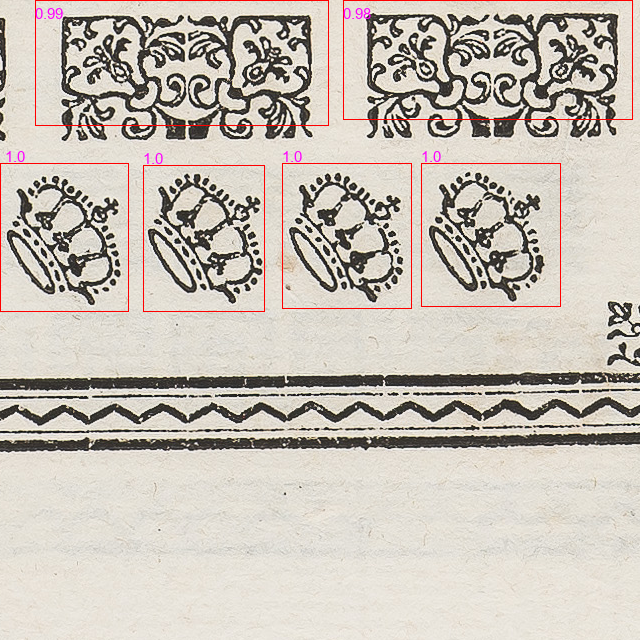

In [ ]:
image

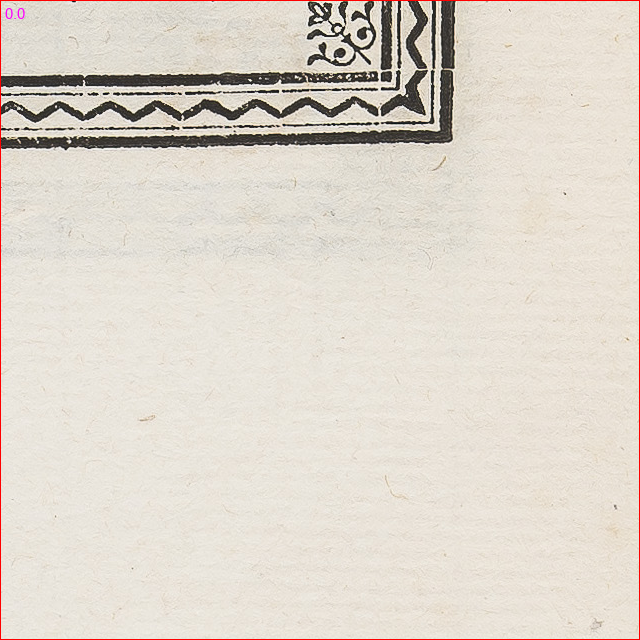

In [ ]:
image,labels,scores,boxes=test(t_img)
image

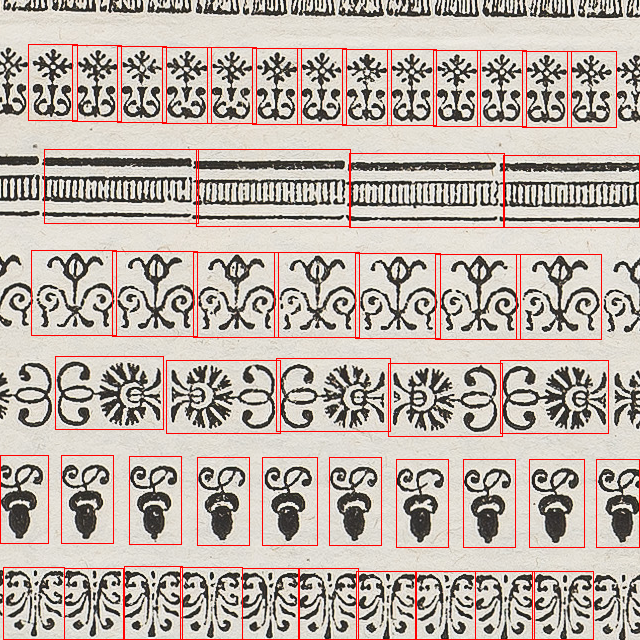

In [ ]:
plot_box(data,400)

# Test with Random Images

In [ ]:
img=np.array(Image.open("/content/gdrive/MyDrive/csv/random_file.jpg"))
img.shape

(640, 640, 3)

In [ ]:
image,labels,scores,boxes=test(img)

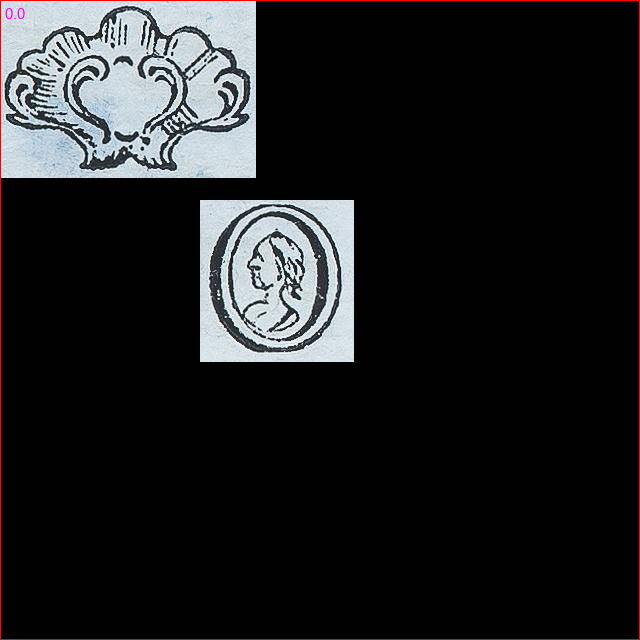

In [ ]:
image

In [ ]:
test_im=Image.open("/content/1766_antiquite devoilee 6_0001 copie.jpg")
test_im.width,test_im.height

(491, 383)

In [ ]:
test_im=test_im.resize((640,640))

In [ ]:
image,labels,scores,boxes=test(np.array(test_im))

In [ ]:
boxes

[array([  0.,   0., 639., 639.], dtype=float32)]

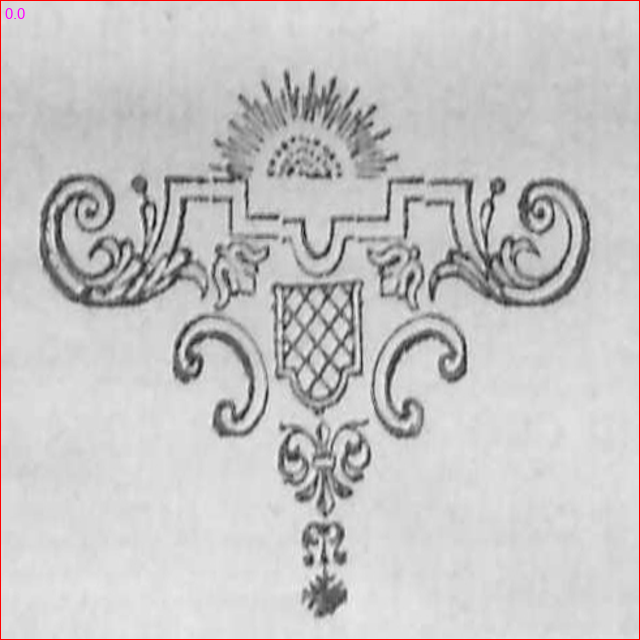

In [ ]:
image

In [ ]:
test_im=Image.open("/content/1766_antiquite devoilee 4_0001 copie.jpg")
test_im.width,test_im.height

(511, 390)

In [ ]:
test_im=test_im.resize((640,640))
image,labels,scores,boxes=test(np.array(test_im))

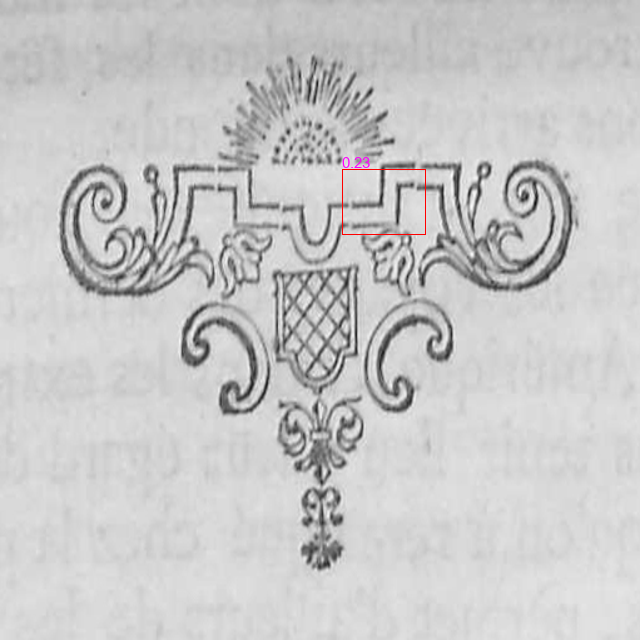

In [ ]:
image

# test with random image
# test with a translation of vignettes

In [ ]:
all_images=data["image_name"].unique()
image_name=all_images[20]
test_img=torch.ones(640,640)


In [ ]:
scores

In [ ]:
boxes

In [ ]:
from SSD.box_utils import cxcy_to_xy

# New Section

# New Section